In [1]:
# Importing the required libraries
import string
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA


#### 5a)  Splitting the Dataset into subsets for training and testing

$\frac{3}{4}$ th of the reviews are used for training while the remaining are used for testing

In [2]:
# reviews_train and reviews_test hold the reviews corresponding to
# training and testing

reviews_train = []
reviews_test = []
train_labels = []
test_labels = []

counter = 0
with  open("movieReviews1000.txt","r") as f:
    for line in f.readlines():
        counter+=1
      
        if counter <=750:
            # If the index of the review is less than 750 then it belongs to the training dataset
            reviews_train.append(line)
          
        else:
            reviews_test.append(line)

In [3]:
def preprocess_text(sentence):
    '''
        preprocess_text(sentence):
            Arguments
                sentence: A sentence
            Output:
                sentence after applying the preprocessing steps
    '''
    words = sentence.split(" ")
    label = int(words[-1])
 
    new_words = []
    for word in words[:-1]:
        
        # Convert the words to lowercase for uniformity
        word = word.lower()  
        
        # Check if the word contains a single punctuation mark other than + which might denote positive and 
        # - which might indicate a negative sentiment    
        if word == "" or ( word in string.punctuation and word != '+' and word != '-' ):
            continue
       
        # Stripping unwanted punctuations within a word
        if word[-1] in ['?',';',':','&']:
            word = word[:-1]
            # Remove whitespaces obtained after preprocessing
            if word=='':
                continue
            new_words.append(word)
        
        new_words.append(word.lower())
            
    # Return the preprocessed sentences which would be passed to the TFIDF Vectorizer
    return  (label,' '.join(new_words))


# Hold the reviews after performing preprocessing steps on each review
cleaned_train_dataset = []
cleaned_test_dataset = []


# Perform preprocessing on the reviews in the training set and store labels of each review
for review in reviews_train:
    label,review = preprocess_text(review)
    cleaned_train_dataset.append(review)
    train_labels.append(label)

# Perform preprocessing on the reviews in the test set and store labels of each review
for review in reviews_test:
    label,review = preprocess_text(review)
    cleaned_test_dataset.append(review)
    test_labels.append(label)

reviews_train = cleaned_train_dataset
reviews_test = cleaned_test_dataset

#### 5b) Performing TF-IDF Vectorizer inorder to get vector representation of each review

In [4]:
#   Package Used :  TF-IDF Vectorizer from sklearn package

tfidfvectorizer = TfidfVectorizer(analyzer='word',stop_words= 'english',sublinear_tf=True)
# Fit the TF-IDF on the reviews in the training set
tf_idf_features = tfidfvectorizer.fit_transform(reviews_train)

# Get the feature matrix corresponding to the reviews in the training set.
train = tf_idf_features.toarray()
train = np.array(train)
print(train.shape)


# Get the  feature matrix corresponding to the reviews in the testing set.
test = tfidfvectorizer.transform(reviews_test).toarray()
test = np.array(test)
print(test.shape)


(750, 2309)
(250, 2309)


#### Perform PCA on the training data set and use the same projection vectors for the points in the test dataset

In [5]:
# Using SKLearn PCA module
pca = PCA(n_components=30)

# Reduce the dimensionality of the feature matrix corresponding to the training set
train = pca.fit_transform(train)
print(train.shape)

# Reduce the dimensionality of the feature matrix corresponding to the test set
test = pca.transform(test)
print(test.shape)

(750, 30)
(250, 30)


### Implementing Logistic Regression Model

The logistic regression model computes the probability of the data point being a particular class as 

$y = sigmoid(W^Tx+b)$  

The loss function 

$E(w,b) = - [\sum^{N}_{n=1} t_nlog(y_n) + (1-t_n)log(1-y_n) ] + \frac{\lambda}{2} w^tw$

##### Gradient Update Rules

$w^{'} = w - \eta(sign)\frac{\partial E}{\partial w}$

$b^{'} = b - \eta(sign)\frac{\partial E}{\partial b}$

where 

$\frac{\partial E}{\partial w} = \frac{1}{N_b}(\sum_{n=1}^{N_b}(y_n - t_n)\underline{x} + \lambda \underline{w} )$

$\frac{\partial E}{\partial b} = \frac{1}{N_b}(\sum_{n=1}^{N_b}(y_n - t_n) +  \lambda*bias)$

In [6]:
class LogisticRegressor:

    '''
        LogisticRegressor
        ----------------------------
            Attributes 
            -----------
            weights : The weight matrix in W^T x + b. Initially set to all 1's
            bias : The bias parameter in W^Tx + b
            learning_rate :  The learning rate while performing stochastic gradient descent
            train_data : Feature matrix corresponding to the reviews in the training set
            valid_data : Feature matrix corresponding to the reviews in the validation set
            train_labels : Vector containing 0's and 1's corresponding to the sentiment of each review in train data
            valid_labels : Vector containing 0's and 1's corresponding to the sentiment of each review in validation data
            epochs: The number of epochs to perform the gradient descent
            batch_size : The batch size in stochastic gradient descent
            regularization : The value of regularization parameter 0 when regularization is not needed
            early_stop : Whether early stopping needs to happen during the training process
            

            Methods
            -----------
            - compute_value  
                Paramters
                    x : A numpy array of shape DimensionxNumber of Data_points
                Returns
                    A numpy array of shape (1 x Number of data points) with each cell having 
                    the value of the probability of belonging to class 1
            
            - sigmoid
                Computes the sigmoid activation function on the numpy array elementwise.
        
            - BCELOSS
                Parameters
                    x:  Numpy array of shape (1 x Batch Size) representing the  probablity values for each review
                    labels: The true label numpy array (Batch size,) used to compute the cross entropy loss
                Returns
                    The cross Entropy loss value

            - compute_loss
                Returns the bce loss + loss term due to regularization if it is present

            - compute_gradient
                Parameters
                    data_points : A numpy array of shape ( No of Dimensions x No of Data Points )
                    labels  : The true label numpy array (No of Data points,)
                    probabilities: The probability values computed by the model
                    bias: Boolean to indicate whether the gradient is to be computer for the bias variable or not

                Output 
                    Model values updated according to gradient descent rule.
                
            - plot_train_validation_losses
                Parameters
                    train_loss : Loss values accumulated during the training process
                    test_loss : Loss values accumulated during the testing process
                Output
                    Plots showing the variation in the training and test loss as a function of the number of epochs

            - compute_parameters
                Parameters
                    train_data : Feature matrix of the training set (No of Data Points x Dimension of each data point)
                    labels : The true label numpy array (Batch Size,)


            - test
                Parameters
                    test_data : Feature matrix corresponding to the test set ( No of Data points x No of Dimensions )
                    labels : The label for each review Dimensions : (No of Data points,)
                Returns
                    Accuracy of the trained Logistic Regression Model on the test set.

    '''

    def __init__(self,initial_bias=1,learning_rate=1,epochs=30,batch_size=32,regularization=0.1,early_stop=False):
        self.weights = np.ones((1,30))
        self.bias = initial_bias
        self.learning_rate = learning_rate
        self.train_data = None
        self.valid_data = None
        self.valid_labels = None
        self.train_labels = None
        self.epochs = epochs
        self.batch_size = batch_size
        self.regularization = regularization
        self.early_stop = False
    
    def compute_value(self,x):
        # Perform sigmoid(W^T x + b)
        return self.sigmoid(np.matmul(self.weights,x) + self.bias)

 
    def sigmoid(self,x):
        # Perform sigmoid function on each element in the numpy array
        return 1.0/(1+np.exp(-x))
    
    def BCELoss(self,x,labels): 
        # Compute the Binary Cross Entropy Loss 
        
        log_x = np.log(x)
        log_1_x = np.log(1.0-x)
        loss = labels*log_x + (1-labels)*log_1_x  # Formula for BCE
        #print(loss)
        return -np.sum(loss) # Sum up the loss over all data points
    
    def compute_loss(self,x,labels):
        # Compute the BCE Loss
        loss = self.BCELoss(x,labels)
        # Add loss term due to regularization if applicable(ie self.regularization != 0)
        loss = loss + self.regularization*np.matmul(self.weights,self.weights.transpose())[0][0]
        return loss
    
    def compute_gradient(self,data_points,labels,probabilities,bias=False):
        
        ans = 0
        if bias==True:
            # Perform gradient computatation for the bias
            ans = probabilities - labels
            ans = ans + self.regularization*self.bias # Re
            ans = np.sum(ans)
        else:
            
            # Perform gradient computatation for the weights
            ans = data_points*(probabilities-labels)
            ans = ans + self.regularization*self.weights.transpose()[0][0]
            ans = np.sum(ans,axis=1)
        
        # Divide by the mini batch size as done in SGD.
        n = data_points.shape[1]
        ans = ans * (1.0/n)
        return ans

    def plot_train_validation_losses(self,train_loss,validation_loss):
        # Plot the training and validation losses
        indices = np.linspace(1,len(train_loss),num=max(len(train_loss),len(validation_loss)))
        
        avg_train_loss = sum(train_loss) / len(train_loss)
        avg_valid_loss = sum(validation_loss) / len(validation_loss)

        plt.title('Batch Size = ' + str(self.batch_size)
            + '\nRegularization Coefficient = ' + str(self.regularization)
            + '\nLearning Rate = ' + str(self.learning_rate)
            + '\nAverage Training loss = ' + str(avg_train_loss) + '\n Average Validation Loss = ' + str(avg_valid_loss))
        plt.xlabel('Epochs')
        plt.ylabel('Loss Value')
        plt.plot(indices,train_loss)
        plt.plot(indices,validation_loss)
        plt.show()

    def compute_parameters(self,train_data,labels):
        
        # Split the training data into training and validation sets 
        indices = np.random.choice(750,size=125,replace=False)
        self.valid_data = train_data[indices]
        self.valid_labels = labels[indices]
        self.train_data = np.delete(train_data,indices,axis=0)
        self.train_labels = np.delete(labels,indices,axis=0)
        
        # Lists for storing the parameters used throughout the training process
        train_loss = []
        validation_loss = []
        trained_weights = []
        trained_biases = []

        # Continue until the number of epochs
        for e in range(self.epochs):
            
            # List storing the  loss values for each mini batch 
            batch_losses = []
            # Batch the training data for training the model
            for i in range(0,self.train_data.shape[0],self.batch_size):
                
                current_training_points = None
                current_training_points_labels  =None
                # If number of data points remaining is less than batch size take the remaining
                if (i + self.batch_size <= self.train_data.shape[0]):
                    current_training_points = self.train_data[i:i+self.batch_size]
                    current_training_points_labels = self.train_labels[i:i+self.batch_size]
                else:
                    # Get the data points belonging to the mini batch
                    current_training_points = self.train_data[i:]
                    current_training_points_labels = self.train_labels[i:]
                
                # Take transpose and feed to compute_value for getting probabilities
                current_training_points = current_training_points.transpose()
                probabilities = self.compute_value(current_training_points)

                # Compute the loss 
                loss = self.compute_loss(probabilities,current_training_points_labels)
                batch_losses.append(loss)

                # Compute the gradients
                weights_gradient = self.compute_gradient(current_training_points,current_training_points_labels,probabilities)
                bias_gradient = self.compute_gradient(current_training_points,current_training_points_labels,probabilities,True)

                #Update the model parameters
                self.weights = self.weights - self.learning_rate*weights_gradient
                self.bias = self.bias - self.learning_rate*bias_gradient
            
            # compute the average batch loss
            average_batch_loss = np.array(batch_losses).mean()
            train_loss.append(average_batch_loss)
            
            # Get the validation data and compute probability values on the validation set
            validation_set = self.valid_data.transpose()
            probabilities = self.compute_value(validation_set)
            loss = self.compute_loss(probabilities,validation_set)
            validation_loss.append(loss)

            # Perform early stopping if configured for early stopping 
            if self.early_stop and len(validation_loss) >1:
                if validation_loss[-2] < loss:
                    print("Early stopping at" + str(e))
                    self.weights = trained_weights[-1]
                    self.bias = trained_biases[-1]
                    break
            if self.early_stop:
                trained_weights.append(np.copy(self.weights))
                trained_biases.append(np.copy(self.bias))
        # Plot the training and validation losses       
        self.plot_train_validation_losses(train_loss,validation_loss)
    
    
    # Perform inference on the testing data
    def test(self,data,labels):
        test_data = data.transpose()
        probabilities = self.compute_value(test_data)
        
        # Count the number of correctly classified points
        count = 0
        for i in range(probabilities.shape[1]):
            predicted_label =None
            if probabilities[0][i]>0.5:
                predicted_label = 1.0
            else:
                predicted_label = 0.0
            
            if (predicted_label == labels[i]):
                count+=1
        
        ans  = ((1.0*count)/data.shape[0])*100
        return ans
                

### 5c)

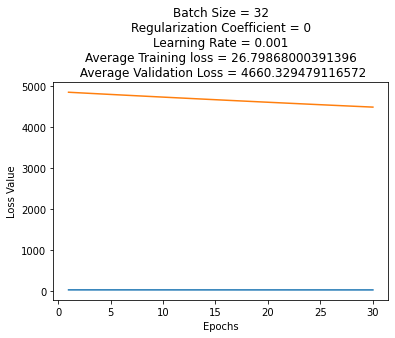

Accuracy = 60.0
-------------------------


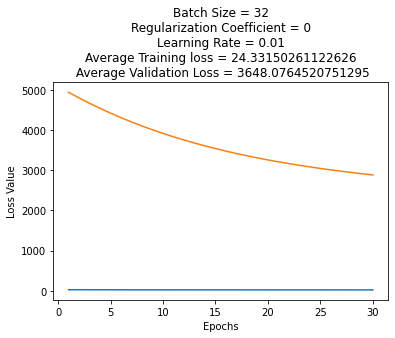

Accuracy = 44.4
-------------------------


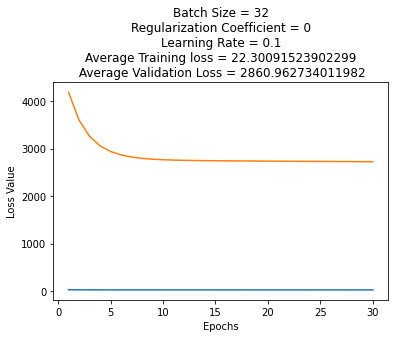

Accuracy = 46.0
-------------------------


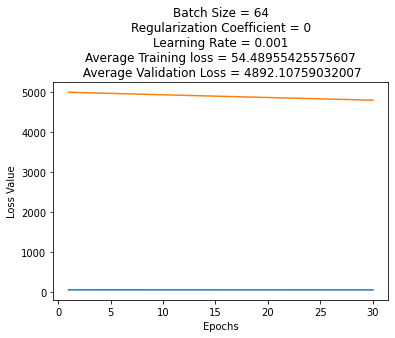

Accuracy = 60.4
-------------------------


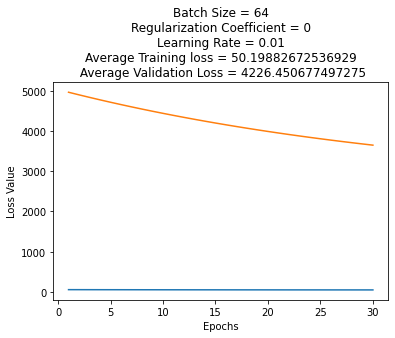

Accuracy = 58.4
-------------------------


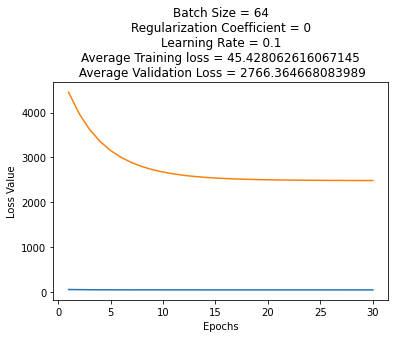

Accuracy = 44.4
-------------------------


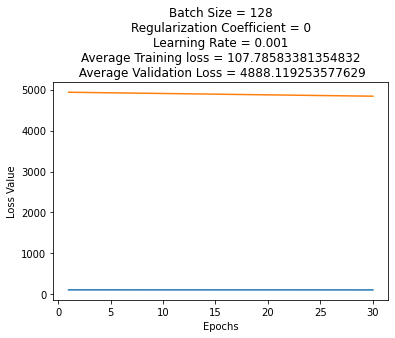

Accuracy = 60.8
-------------------------


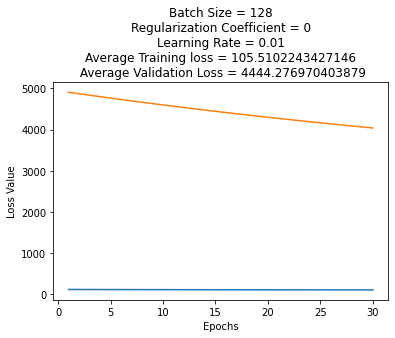

Accuracy = 59.599999999999994
-------------------------


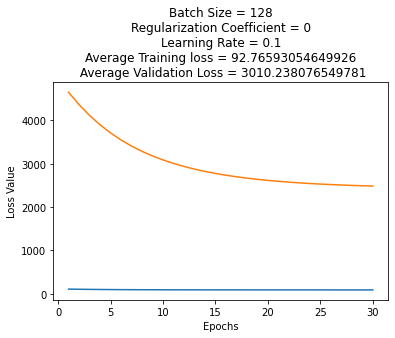

Accuracy = 42.4
-------------------------


In [7]:
batch_sizes = [32,64,128]
learning_rates = [1e-3,1e-2,1e-1]

# Get the performance estimates without early stopping 
for batch in batch_sizes:
    for lr in learning_rates:
        reg = LogisticRegressor(learning_rate=lr,batch_size=batch,regularization=0,early_stop=False)
        reg.compute_parameters(train,np.array(train_labels))
        print("Accuracy = " + str(reg.test(test,np.array(test_labels))))
        print("-------------------------")



#### Observations

Accuracy summarization (Averaged over various runs)


|  	|   0.001	| 0.01 	|   0.1	|  
|---	|---	|---	|---	|
|  32 	|   61.1	|  48.4 	|   46.8	|   	
|   64	|   61.1	|  56.0 	|   43.6	|   
|   128	|   61.1	|  60.8 	|   42.4	|  

- Values for the accuracy for the learning rate 0.01 remains almost constant through the batch size 
- There was a notable increase in accuracy on the test set with increasing batch size in learning rate 0.01
- There was a slight decrease in accuracy values with increasing batch size for the learning rate parameter set to 0.1
- An increase in the learning rate caused accuracies to decrease irrespective of batch size


#### 5d)

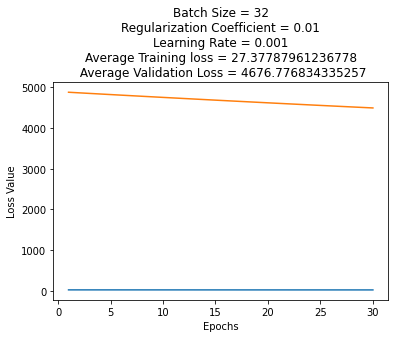

Accuracy = 60.0
-------------------------


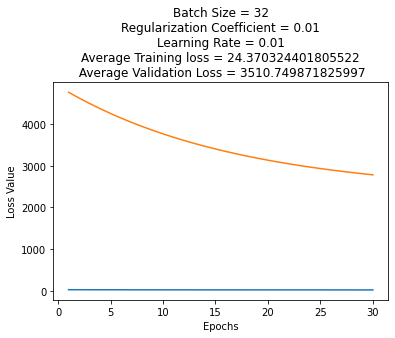

Accuracy = 46.400000000000006
-------------------------


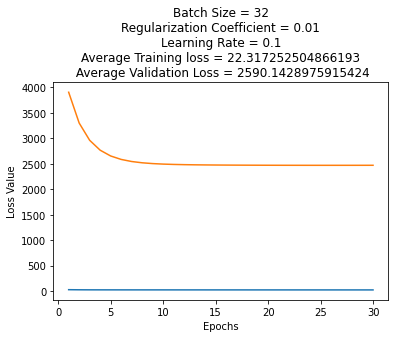

Accuracy = 47.599999999999994
-------------------------


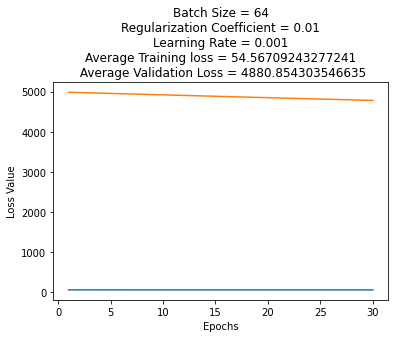

Accuracy = 60.4
-------------------------


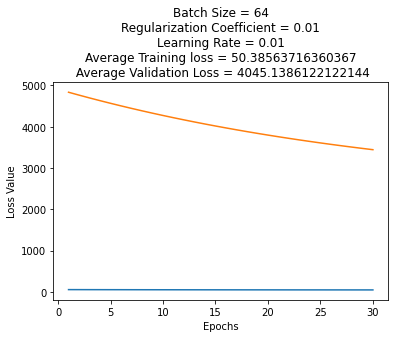

Accuracy = 57.199999999999996
-------------------------


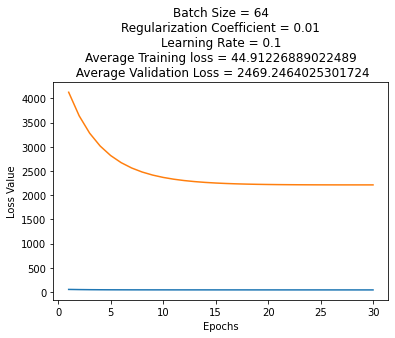

Accuracy = 42.0
-------------------------


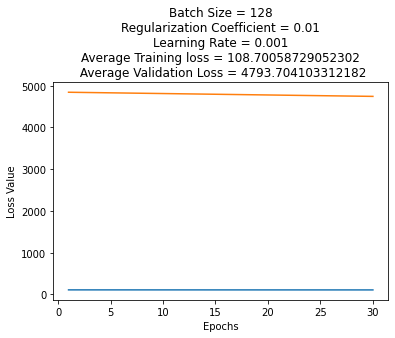

Accuracy = 60.8
-------------------------


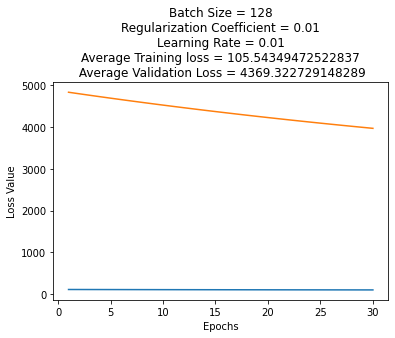

Accuracy = 59.599999999999994
-------------------------


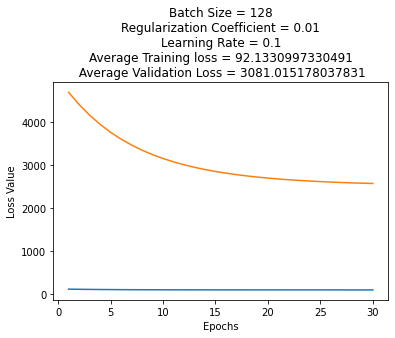

Accuracy = 42.4
-------------------------


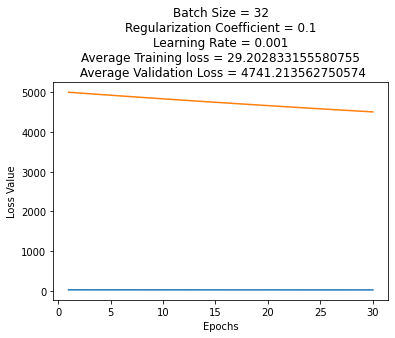

Accuracy = 60.0
-------------------------


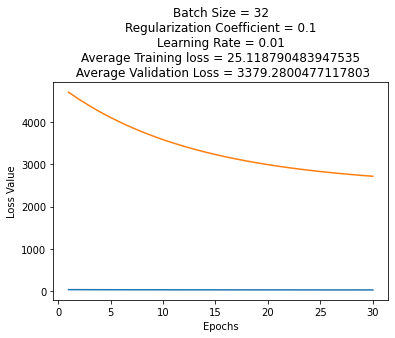

Accuracy = 47.199999999999996
-------------------------


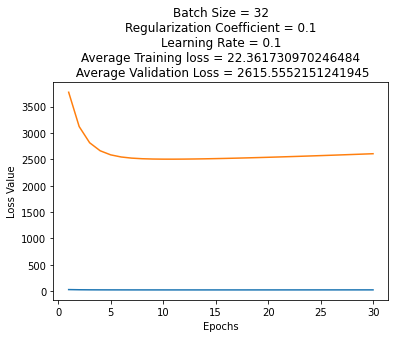

Accuracy = 48.0
-------------------------


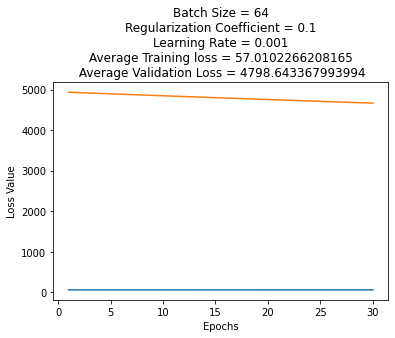

Accuracy = 60.4
-------------------------


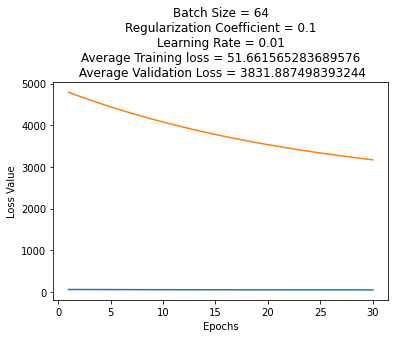

Accuracy = 55.60000000000001
-------------------------


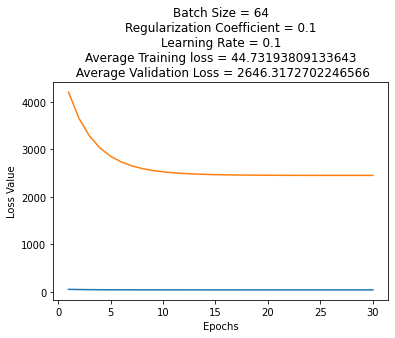

Accuracy = 46.800000000000004
-------------------------


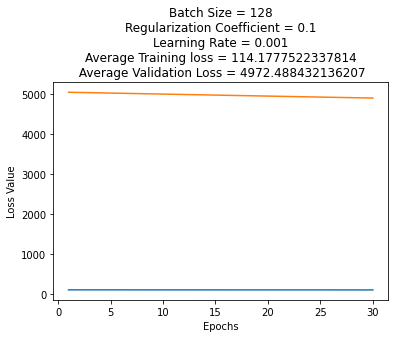

Accuracy = 60.8
-------------------------


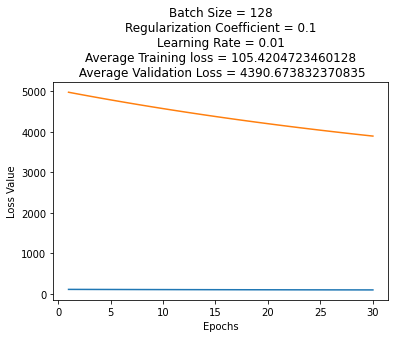

Accuracy = 59.599999999999994
-------------------------


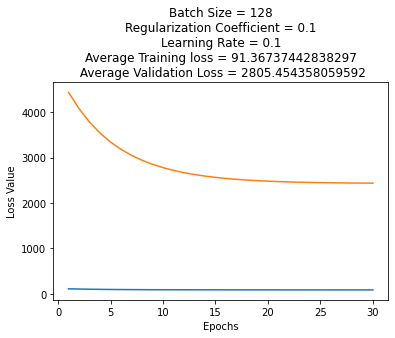

Accuracy = 44.4
-------------------------


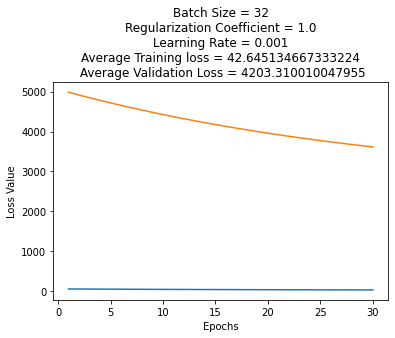

Accuracy = 60.0
-------------------------


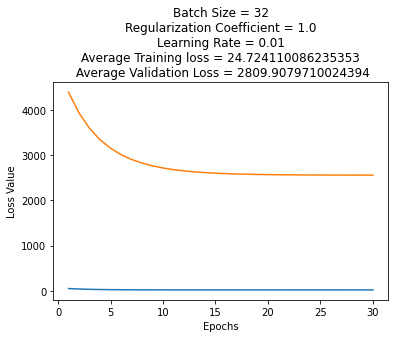

Accuracy = 46.0
-------------------------


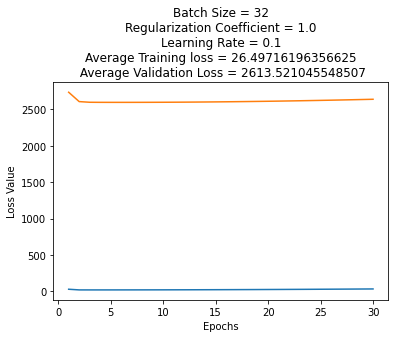

Accuracy = 49.6
-------------------------


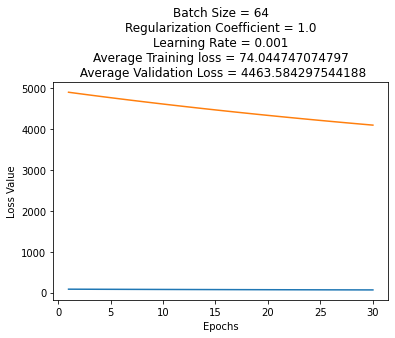

Accuracy = 60.4
-------------------------


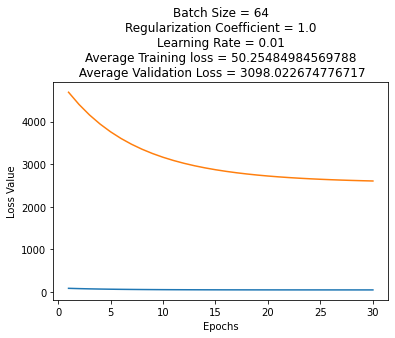

Accuracy = 45.2
-------------------------


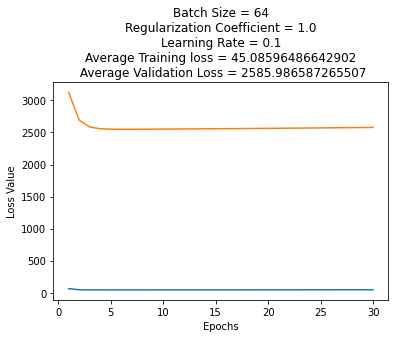

Accuracy = 48.4
-------------------------


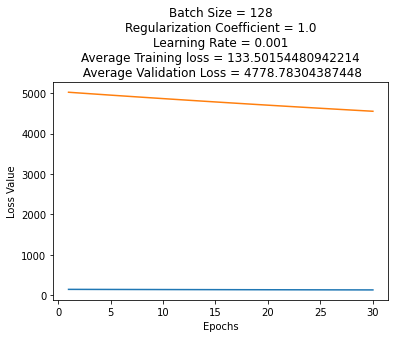

Accuracy = 60.8
-------------------------


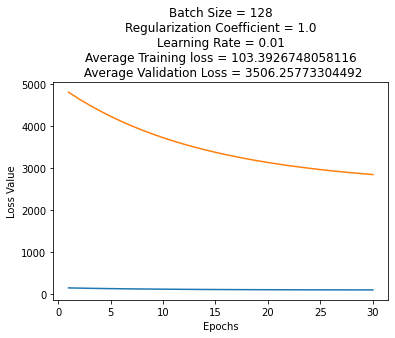

Accuracy = 59.599999999999994
-------------------------


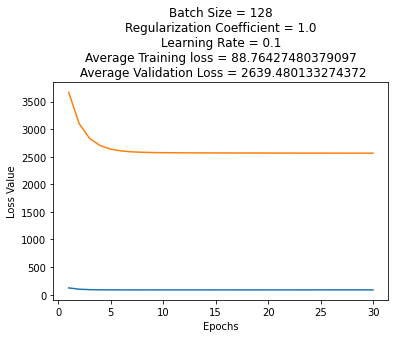

Accuracy = 48.8
-------------------------


In [8]:
# Get the performance estimates with early stopping 
regularization_coefficients = [0.01,0.1,1.0]
for r in regularization_coefficients:
    for batch in batch_sizes:
        for lr in learning_rates:
            reg = LogisticRegressor(learning_rate=lr,batch_size=batch,regularization=r,early_stop=False)
            reg.compute_parameters(train,np.array(train_labels))
            print("Accuracy = " + str(reg.test(test,np.array(test_labels))))
            print("-------------------------")


#### Observations

- There are signs of underfitting in loss graphs where the validation loss curve has a scope for further decrease 
- There are signs of overfitting which is significant in the loss curves of the following set of parameters
    -   Batch Size = 32, Regularization Coefficient = 1.0,  Learning Rate = 0.1
    -   Batch Size = 64, Regularization Coefficient = 1.0,  Learning Rate = 0.1
    -   Batch Size = 128, Regularization Coefficient = 1.0,  Learning Rate = 0.1 
    In these curves the validation loss curve decreases and then we can see that there is a slight increase after some epoch
    This is a clear sign of a model which is overfitting.

- The model parameters which gave a validation curve almost similar to a straight line gave the highest accuracy among the parameter choices.



### Accuracy summarization (Averaged over various runs)

Regularization coefficient : 0.01

|  	|   0.001	| 0.01 	|   0.1	|  
|---	|---	|---	|---	|
|  32 	|   59	|  47.14	|   48.4	|   	
|   64	|   59.8	|  57.59	|   44.8	|   
|   128	|   60	|  59	|   42.4	|  


Regularization coefficient : 0.1

|  	|   0.001	| 0.01 	|   0.1	|  
|---	|---	|---	|---	|
|  32 	|   59.9	|  44.4 	|  48.4 	|   	
|   64	|   59.59	|  57.59 	|   47.19	|   
|   128	|   60	|  59.19 	|   44.8	|  



Regularization coefficient : 1

|  	|   0.001	| 0.01 	|   0.1	|  
|---	|---	|---	|---	|
|  32 	|   59.9	|  47.59	|   48.8	|   	
|   64	|   59.59	|  45.2 	|  48.0	|   
|   128	|   58.8	|  58.8	|   48.4	|  